
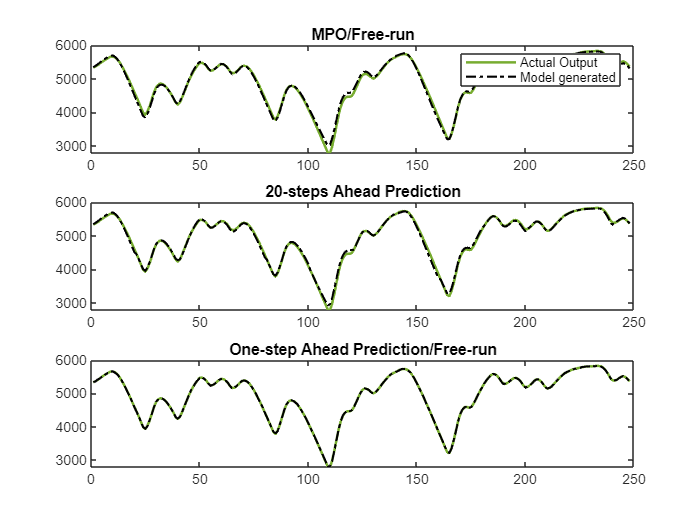

--------------------
MSSE = 3601.6419
MSkPE = 2017.5142
MSPE = 66.0511
--------------------

In [1]:
%% Clear workspace and add NonSydID to the search path
clear;clc
addpath('\...\NonSysID');
%% Import data

u = readmatrix('\...\Examples\Electro-mecahnical system\Data\x_cc.csv');
y = readmatrix('\...\Examples\Electro-mecahnical system\Data\y_cc.csv');

%--- Down sample data ---%
dwn_smpl = 100;
u = u(1:dwn_smpl:end);
y = y(1:dwn_smpl:end);
%% System Identification - NonSysID
tt_splt = 100:350; %Training samples of data
u_ID=u(tt_splt);
y_ID=y(tt_splt);

% Model type ARX/AR
mod_type = 'ARX';

% Maximum and minimum output lags
na1=1;na2=3;

% Maximum and minimum input lags
nb1=1;nb2=3;

% Maximum order of polynomial nonlinearity considered
nl_ord_max=2;

% Run more than one iteration of iOFR for [linear model ,nonlinear model]
x_iOFR = [true,true];

% Stoping criteria for [linear model ,nonlinear model]. PRESS_thresh/BIC_thresh
stp_cri = {'PRESS_thresh', 'PRESS_thresh'};
% Set value for stopping criteria for [linear model ,nonlinear model]
% The stopping criteria relates to how many terms are added to the model
D1_thresh = [10^(-10),10^(0.9)];

% Specify if bias/DC off set is required, 0, or not, 1.
is_bias=0;

% Specify number of inputs
n_inpts=1;

% Specify the number of steps for k-steps ahead prediction
KSA_h=20;

% Specify which RCT (Reduce Computational Time) method to use, 1-4, 0 for
% no RCT.
RCT=4;

% Specify whether to simulate model and display results respectively
sim=[1,1];
% Set to 1 to display all models generated from iOFRs, 0 otherwise
displ=0;
% Set 1 or 0 to use parallel processing to accelerate iOFRs, for [linear model ,nonlinear model]
parall = [1,1];

% Run NonSysID
tic
[model, Mod_Val_dat, iOFR_table_lin, iOFR_table_nl, best_mod_ind_lin, best_mod_ind_nl, val_stats] = ...
    NonSysID(mod_type,u_ID,y_ID,na1,na2,nb1,nb2,nl_ord_max,is_bias,n_inpts,KSA_h,RCT,x_iOFR,stp_cri,D1_thresh,displ,sim,parall);

In [2]:
toc

Elapsed time is 0.226388 seconds.

In [3]:

disp('ARX model:'); disp(iOFR_table_lin{best_mod_ind_lin,1});

ARX model:
                  ERR         theta 
               __________    _______
    y1(t-1)     0.0035628     2.4274
    y1(t-2)    0.00010674    -1.9559
    y1(t-3)        0.9963    0.52645
    u1(t-1)    1.3124e-05     10.668
    u1(t-3)    3.8288e-06    -6.8021

In [4]:
if best_mod_ind_nl~=0
    disp('NARX model:');
    tbl_NARX = join(iOFR_table_nl{best_mod_ind_nl,10},iOFR_table_nl{best_mod_ind_nl,1});disp(tbl_NARX);
end

NARX model:
                      MS_PRESS_E      theta         ERR    
                      __________    _________    __________
    y1(t-1)               8128.5       1.7844       0.49526
    y1(t-2)               975.85     -0.79156    0.00028497
    u1(t-1)               318.88       47.205    2.6363e-05
    y1(t-2)u1(t-1)        158.23    -0.037612     6.211e-06
    y1(t-3)u1(t-1)    1.2306e+07     0.030086       0.50441
    u1(t-2)u1(t-2)        91.271         1.89    2.5147e-06
    u1(t-2)u1(t-3)        71.842     -0.91694    7.2261e-07


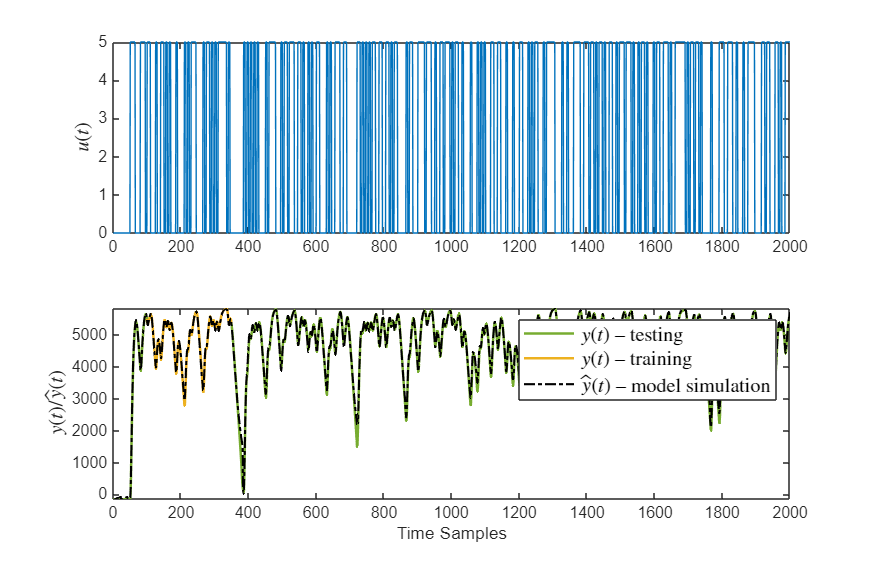

In [5]:
%% Simulate model
[sse, y_hat, error, U_delay_mat_sim] = model_simulation(model,u,y,KSA_h);

%----------
figure('OuterPosition',[237 224.2 897.6 577.6]);
subplot(2,1,1); plot(u, 'Color', '#0072BD'); axis([0 2000 -inf inf]);
ylabel(' !!!EQ_1!!! ','Interpreter','latex','FontSize',12);
%----------
n = length(y);
subplot(2,1,2);
plot(1:n, y,'Color', '#77AC30', 'LineWidth', 1.5); hold on; axis([0 2000 -inf inf]);
plot(tt_splt, y_ID, 'Color', '#EDB120','LineWidth', 1.5); hold on; axis([0 2000 -inf inf]);
plot((length(y)-length(y_hat)+1:n), y_hat(:,3), 'k-.', 'LineWidth',1.25); axis([0 2000 -inf inf]);
legend(' !!!EQ_2!!!  -- testing', ' !!!EQ_2!!!  -- training',' !!!EQ_4!!!  -- model simulation','Interpreter','latex','FontSize',12);
xlabel('Time Samples');
ylabel(' !!!EQ_5!!! ','Interpreter','latex','FontSize',12);

In [6]:
%----------

disp(['RMSE = ',num2str( sqrt(mean(error(:,1).^2)) )]);

RMSE = 177.6604

In [7]:
disp(['Error variance = ',num2str( var(error(:,1)) )]);

Error variance = 26015.6385


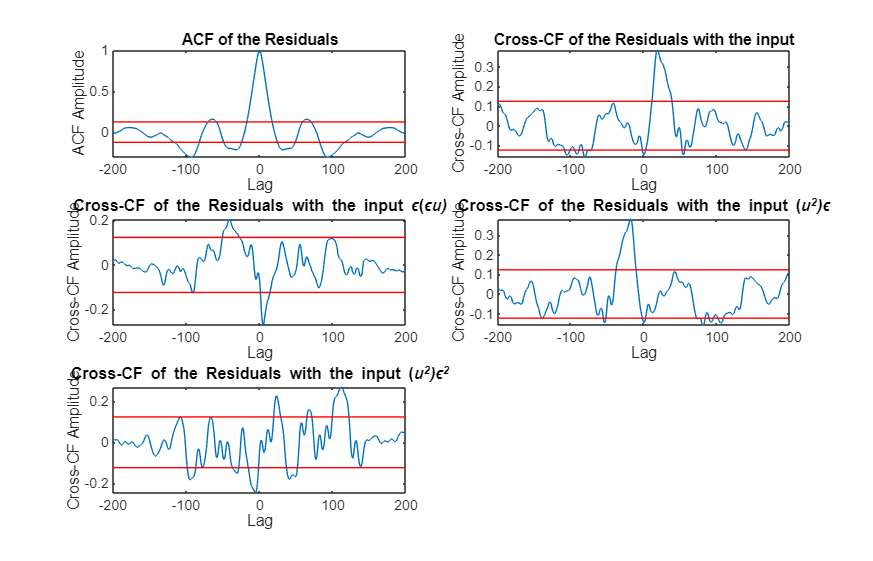

In [8]:

%% Correlation based statistical validation OSA based
% Normalise error and input
% Specify which error to use
e_ct = error(tt_splt,1); % simulation, one-step ahead or k-steps ahead (1,2,3 respectively)
u_ct = U_delay_mat_sim(tt_splt,1);
u_ct = u_ct - mean(u_ct);
u_ct = u_ct ./ std(u_ct);
e_ct = e_ct - mean(e_ct);
e_ct = e_ct ./ std(e_ct);
[~,~] = ac_cc_model_valid_nl(e_ct,u_ct,200,1);


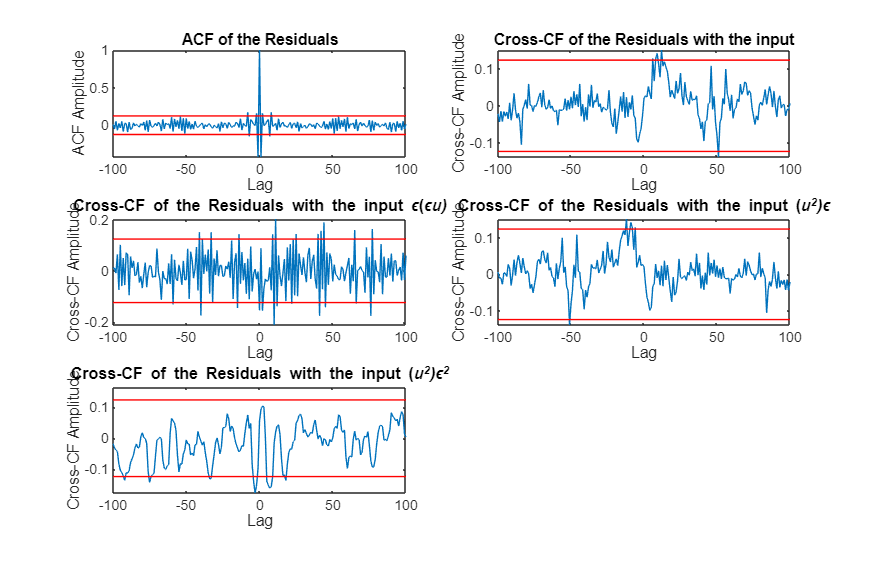

In [9]:

%% Correlation based statistical validation MPO based
% Normalise error and input
% Specify which error to use
e_ct = error(tt_splt,2); % simulation, one-step ahead or k-steps ahead (1,2,3 respectively)
u_ct = U_delay_mat_sim(tt_splt,1);
u_ct = u_ct - mean(u_ct);
u_ct = u_ct ./ std(u_ct);
e_ct = e_ct - mean(e_ct);
e_ct = e_ct ./ std(e_ct);
[~,~] = ac_cc_model_valid_nl(e_ct,u_ct,100,1);